In [1]:
# importing the required libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows',None)

In [2]:
# Loading the dataset
df_train = pd.read_csv('Health_Insurance_train.csv')
#df_test = pd.read_csv('Health_Insurance_test.csv')
#df_tst_op = pd.read_csv('sample_submission.csv')  # contains zero for all the entries

In [3]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df_train.shape

(381109, 12)

In [5]:
# Checking for any null value in the dataset
df_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
df_train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

#### Steps to be performed :
1. Encode the categorical variables ['Gender','Vehicle_Age','Vehicle_Damage']
2. Encode the numerical categorical variables. ['Policy_Sales_Channel','Region_Code'] 

In [7]:
# Creating a function for encoding categorical features (step 1)
def cat_encode(df):
    df['Gender_en'] = np.where(df['Gender']=='Male',1,0)
    df['Vehicle_Damage_en'] = np.where(df['Vehicle_Damage']=='Yes',1,0)
    df['Vehicle_Age_Orig'] = df['Vehicle_Age']
    df = pd.get_dummies(df,columns=['Vehicle_Age'],drop_first=True)
    #df.drop(['Gender','Vehicle_Age_Orig','Vehicle_Damage','id'],axis=1,inplace=True)    
    return df


In [8]:
# Calling the encoding function and storing resultant data into df
df = cat_encode(df_train)

In [9]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_en,Vehicle_Damage_en,Vehicle_Age_Orig,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,Male,44,1,28.0,0,Yes,40454.0,26.0,217,1,1,1,> 2 Years,0,1
1,2,Male,76,1,3.0,0,No,33536.0,26.0,183,0,1,0,1-2 Year,0,0
2,3,Male,47,1,28.0,0,Yes,38294.0,26.0,27,1,1,1,> 2 Years,0,1
3,4,Male,21,1,11.0,1,No,28619.0,152.0,203,0,1,0,< 1 Year,1,0
4,5,Female,29,1,41.0,1,No,27496.0,152.0,39,0,0,0,< 1 Year,1,0


In [10]:
#['Policy_Sales_Channel','Region_Code']

#Target Encoding the above categorical features (step 2)

Pol_sal = df.groupby('Policy_Sales_Channel')['Response'].mean().sort_values().to_dict()
Reg_cod = df.groupby('Region_Code')['Response'].mean().to_dict()

df['Policy_Sales_Channel_en'] = df['Policy_Sales_Channel'].map(Pol_sal)
df['Region_Code_en'] = df['Region_Code'].map(Reg_cod)

df_original = df.copy()
# Dropping the columns that are unimportant
df.drop(['Gender','Vehicle_Age_Orig','Vehicle_Damage','id','Policy_Sales_Channel','Region_Code'],axis=1,inplace=True)
df.head()

,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,Gender_en,Vehicle_Damage_en,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Policy_Sales_Channel_en,Region_Code_en
0,44,1,0,40454.0,217,1,1,1,0,1,0.199385,0.187163
1,76,1,0,33536.0,183,0,1,0,0,0,0.199385,0.127662
2,47,1,0,38294.0,27,1,1,1,0,1,0.199385,0.187163
3,21,1,1,28619.0,203,0,1,0,1,0,0.028624,0.112760
4,29,1,1,27496.0,39,0,0,0,1,0,0.028624,0.121776


In [11]:
# Checking if the dataset is balanced
print(df['Response'].value_counts(normalize=True))

X = df.drop(['Response'],axis=1)
y = df.Response

0    0.877437
1    0.122563
Name: Response, dtype: float64


In [12]:
# Since the dataset is imbalanced, we apply sampling techniques on the dataset
# Using combination of oversampling and undersampling
from imblearn.combine import SMOTETomek
st = SMOTETomek(sampling_strategy=0.7)
X_new, y_new = st.fit_resample(X,y)


# Checking the balance ratio afte resampling
y_new.value_counts(normalize=True)

0    0.593148
1    0.406852
Name: Response, dtype: float64

### 1. Using LogisticRegression for prediction

In [13]:
# Using the LogisticRegression for classification and checking the score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
lr_model = LogisticRegression()

X_train,X_test,y_train,y_test = train_test_split(X_new,y_new,test_size=0.3,random_state=42)

scores = cross_val_score(lr_model,X_train,y_train,scoring="accuracy",cv=5)
scores.mean()


0.710041584817459

In [14]:
## Checking the accuracy for test data
lr_model.fit(X_train,y_train)

y_pred = lr_model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.88      0.71     95949
           1       0.44      0.14      0.21     65600

    accuracy                           0.58    161549
   macro avg       0.52      0.51      0.46    161549
weighted avg       0.53      0.58      0.51    161549



### 2. Preliminary DecisionTree model 
Since the LogisticRegression is not performing well on prediction. Trying DecitionTree.

In [15]:
# Using Preliminary DecisionTree model for prediction
from sklearn.tree import DecisionTreeClassifier

dt_mod = DecisionTreeClassifier(ccp_alpha=0.0)

dt_mod.fit(X_train,y_train)
y_hat = dt_mod.predict(X_test)

accuracy_score(y_test,y_hat)

0.8721440553640072

In [16]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     95949
           1       0.84      0.85      0.84     65600

    accuracy                           0.87    161549
   macro avg       0.87      0.87      0.87    161549
weighted avg       0.87      0.87      0.87    161549



### 3. Finding the optimum value for ccp_alpha for DecisionTree

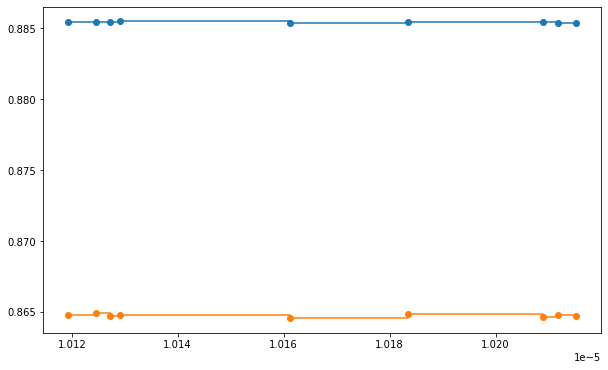

In [17]:
# Pruning the DecisionTree
ccp_alphas = dt_mod.cost_complexity_pruning_path(X_train,y_train)['ccp_alphas']
ccp_alphas_list = ccp_alphas[:-1]

# Plotting the scores for each alpha values Decision Tree
scores_list_train = []
scores_list_test = []
ccp_list = ccp_alphas[(ccp_alphas>1.01154796e-05) & (ccp_alphas<1.02208147e-05)]
for alpha in ccp_list:
    dt_mod = DecisionTreeClassifier(ccp_alpha=alpha)
    scores_train = cross_val_score(dt_mod,X_train,y_train,cv=5,n_jobs=-1)
    scores_test = cross_val_score(dt_mod,X_test,y_test,cv=5,n_jobs=-1)
    scores_list_train.append(np.mean(scores_train))
    scores_list_test.append(np.mean(scores_test))
    
plt.figure(figsize=(10,6))
plt.plot(ccp_list,scores_list_train,marker='o',drawstyle='steps-post')
plt.plot(ccp_list,scores_list_test,marker='o',drawstyle='steps-post')


In [18]:
# Using the optimal value from the above plot
optimal = 1.01991797e-05

from sklearn.metrics import roc_auc_score
# Using the optimized value for ccp_alpha
dt_mod = DecisionTreeClassifier(ccp_alpha=optimal)
dt_mod.fit(X_train,y_train)
y_pred = dt_mod.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'roc-auc_score: {roc_auc_score(y_test,y_pred)}')

Accuracy: 0.8885786974849736
roc-auc_score: 0.8737236153816725


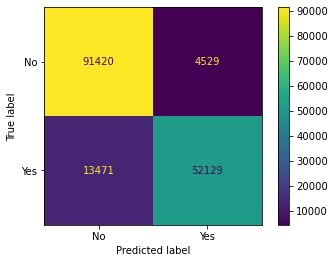

In [20]:
# Plotting the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dt_mod,X_test,y_test, display_labels=['No','Yes'])

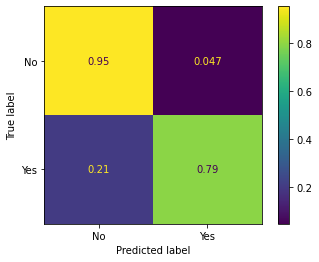

In [23]:
# Plotting the confusion matrix with normalized values
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dt_mod,X_test,y_test, display_labels=['No','Yes'],normalize='true')